In [5]:
import torch
import torch.optim
import torch.nn as nn
from torchvision import datasets, transforms as T
import torch.utils.data

In [3]:
train_transforms = T.Compose([
        
        T.Resize((100,100)),
  
        T.ToTensor()])

In [4]:
dataset = datasets.ImageFolder('./Sohas_weapon-Classification', transform=train_transforms)


In [5]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)

[2023-11-22 04:39:26.487 pytorch-1-13-cpu-py39-ml-t3-medium-4b3434294f9e11099fbdf101536f:81 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-11-22 04:39:27.358 pytorch-1-13-cpu-py39-ml-t3-medium-4b3434294f9e11099fbdf101536f:81 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


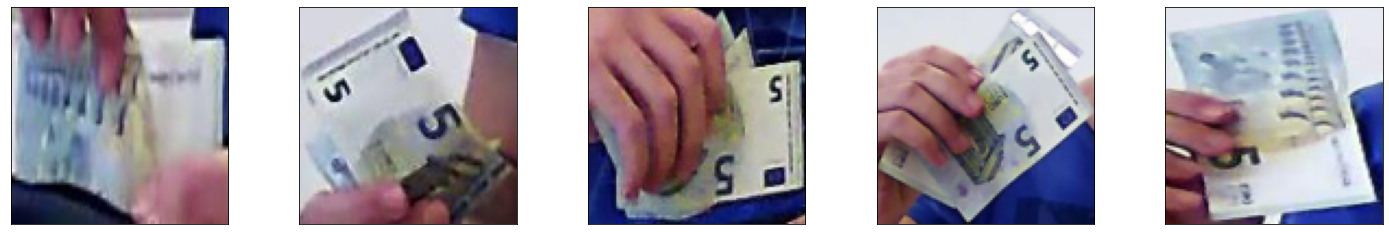

In [6]:
import matplotlib.pyplot as plt

dataiter  = iter(dataloader)
images, labels  = next(dataiter)

images = torch.permute(images, (0, 2, 3, 1)).clip(0, 1)

fig = plt.figure(figsize=(25, 4))

for idx in range(5):
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx])


In [7]:
class MyModel(nn.Module):
    def __init__(self):

        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(64, 128, 3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            
            nn.Linear(128, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, 6)
            
        )

    def forward(self, x):
        x = self.model(x)
        return x


In [8]:
loss  = nn.CrossEntropyLoss()

In [9]:
model = MyModel()

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=0.005)

In [12]:
if torch.cuda.is_available():
    model.cuda()
    
total = len(dataloader)*16

for epoch in range(10):
    model.train()
    train_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        opt.zero_grad()
        output = model(data)
        loss_value  = loss(output, target)
        loss_value.backward()
        opt.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct = correct + torch.sum(torch.squeeze(pred.eq(target.data.view_as(pred))))
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss))
    acc = correct/total
    print(f'Epoch: {epoch +1} train_loss: {train_loss}')
    print(f'Epoch: {epoch +1} accuracy: {acc}')

Epoch: 0 train_loss: 1.5956398848712543
Epoch: 0 accuracy: 0.4726758897304535
Epoch: 1 train_loss: 1.3554960979052035
Epoch: 1 accuracy: 0.5745393633842468
Epoch: 2 train_loss: 1.5010278349995012
Epoch: 2 accuracy: 0.5368509292602539
Epoch: 3 train_loss: 1.4264543118014612
Epoch: 3 accuracy: 0.5136097073554993
Epoch: 4 train_loss: 1.1756134894731123
Epoch: 4 accuracy: 0.6886515617370605
Epoch: 5 train_loss: 1.2479919275897593
Epoch: 5 accuracy: 0.6210217475891113
Epoch: 6 train_loss: 1.2364613247233476
Epoch: 6 accuracy: 0.6404941082000732
Epoch: 7 train_loss: 1.181344945506515
Epoch: 7 accuracy: 0.6600711941719055
Epoch: 8 train_loss: 1.1698754690759121
Epoch: 8 accuracy: 0.6263609528541565
Epoch: 9 train_loss: 1.218014457324478
Epoch: 9 accuracy: 0.6143215894699097


In [13]:
torch.save(model.state_dict(), './Trained-Models/custom_cnn.pt')

In [8]:
model_reload = MyModel().cpu()

In [9]:
model_reload.load_state_dict(torch.load('./Trained-Models/custom_cnn.pt', map_location='cpu'))

<All keys matched successfully>

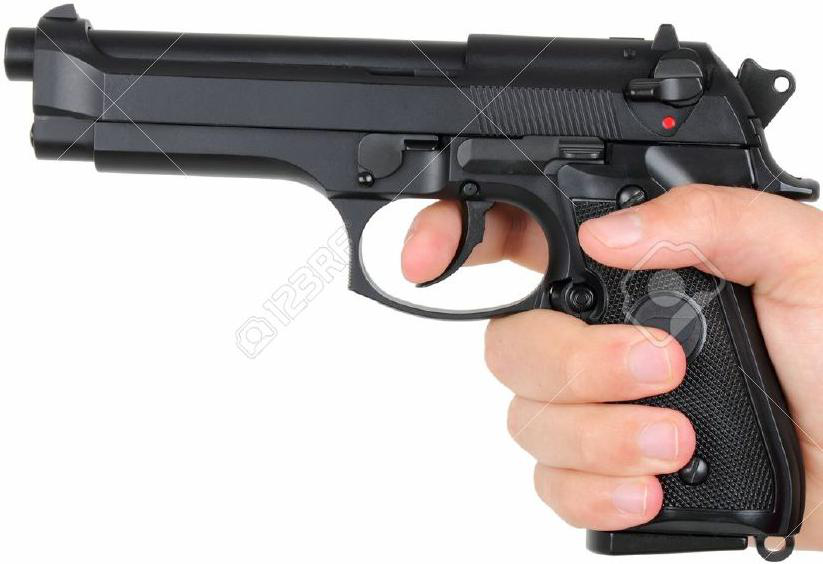

In [10]:
from PIL import Image 
  
im = Image.open(r'./Sohas_weapon-Classification/pistol/pistol_0028_box1.jpg')  
   
im.show() 

In [11]:
convert_tensor = T.ToTensor()
im =convert_tensor(im)

In [12]:
with torch.no_grad():
    model_reload.eval()
    out=model_reload(im.unsqueeze(dim=0))

In [13]:
import torch.nn.functional as F
x  = F.softmax(out, dim=1)

In [14]:
x

tensor([[0.0746, 0.0490, 0.0215, 0.0901, 0.5278, 0.2370]])

In [64]:
dataset.class_to_idx

{'billete': 0,
 'knife': 1,
 'monedero': 2,
 'pistol': 3,
 'smartphone': 4,
 'tarjeta': 5}